In [1]:
import re
import math
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from urllib.parse import urlparse

In [2]:
data = pd.read_csv("Spam.csv")
data.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign


## Creating heatmap and finding correlations for feature engineering:

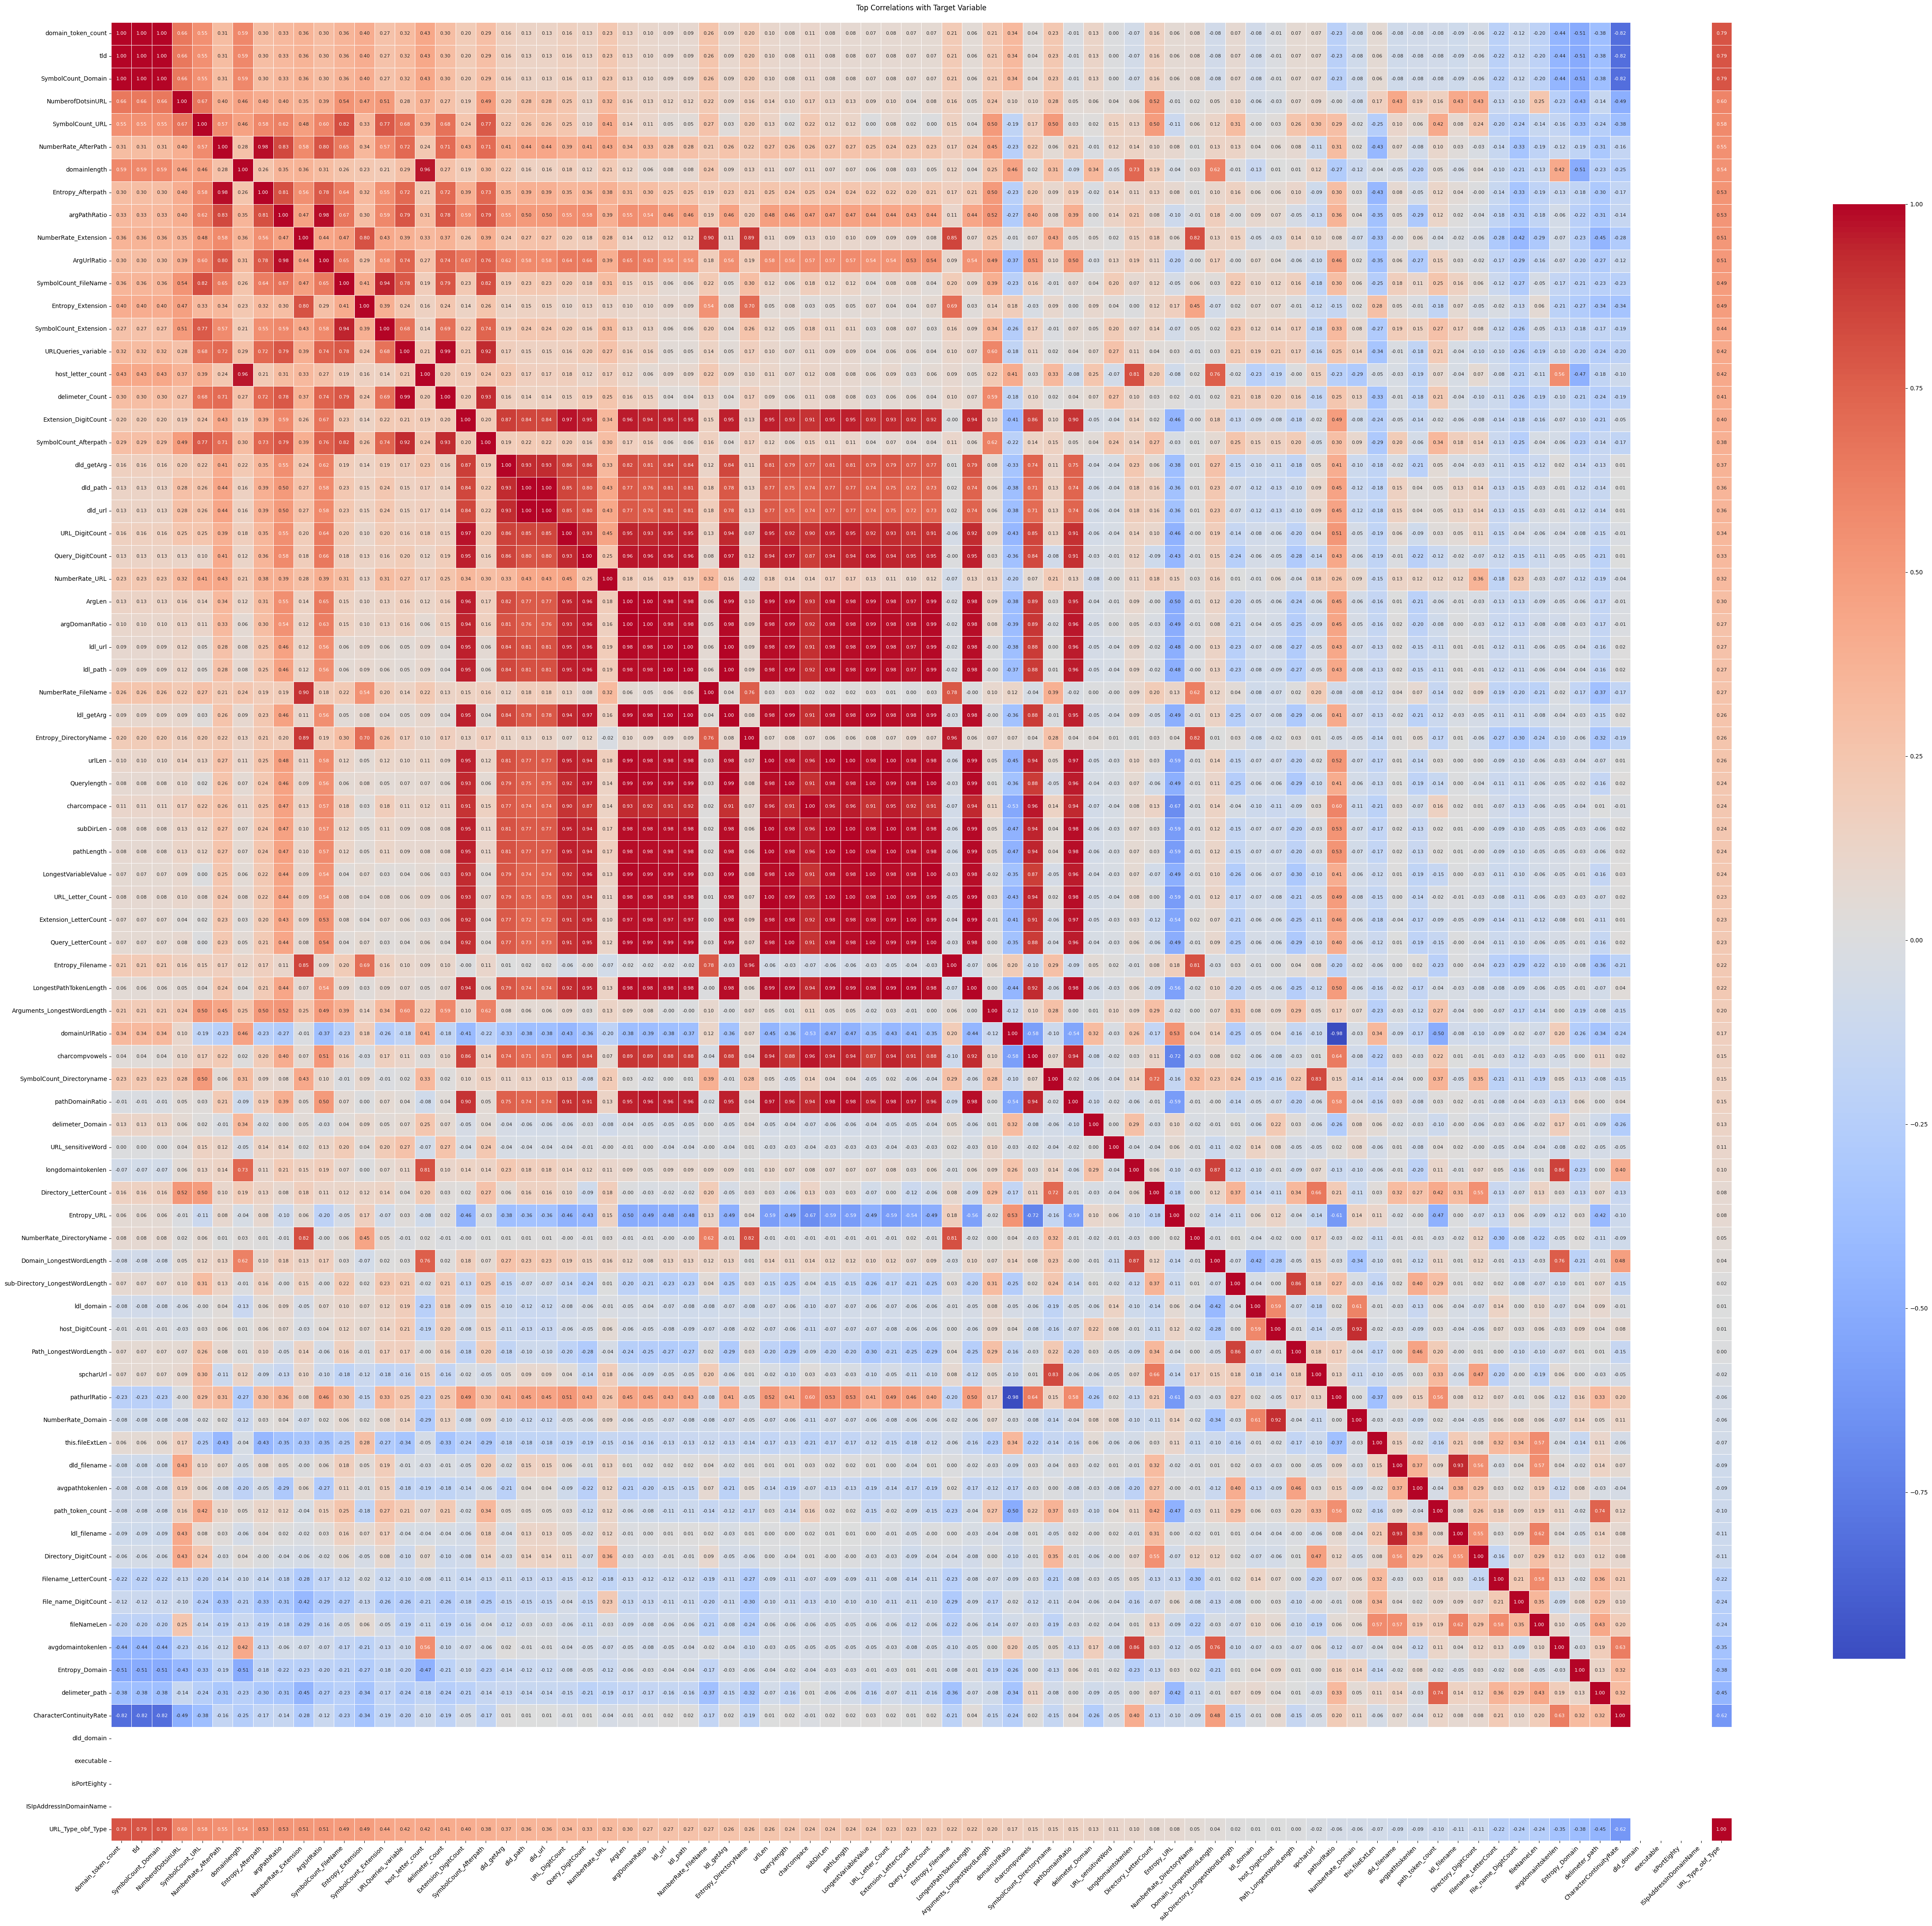

In [3]:
# Convert target variable to numeric
data['URL_Type_obf_Type'] = data['URL_Type_obf_Type'].map({'benign': 0, 'spam': 1})

# Compute correlations with target
corr_matrix = data.corr()
target_corr = corr_matrix['URL_Type_obf_Type'].sort_values(ascending=False)

top_n = len(data)
top_features = target_corr[1:top_n+1].index.tolist()  # Exclude target itself
top_features.append('URL_Type_obf_Type')  # Add target back for visualization

# Create subset correlation matrix
subset_corr = corr_matrix.loc[top_features, top_features]

# Plot adjusted heatmap
plt.figure(figsize=(50, 45))
sns.heatmap(
    subset_corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={'size': 8},
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Top Correlations with Target Variable', pad=20)
plt.tight_layout()
plt.show()

In [4]:
# Get correlation values with the target column (excluding the target itself).
target_corr = corr_matrix['URL_Type_obf_Type'].drop('URL_Type_obf_Type')

target_corr_sorted = target_corr.abs().sort_values(ascending=False)
print("Top 15 features most correlated with the target class:")
print(target_corr_sorted.head(15))

Top 15 features most correlated with the target class:
domain_token_count         0.794285
tld                        0.794285
SymbolCount_Domain         0.794285
CharacterContinuityRate    0.615934
NumberofDotsinURL          0.599882
SymbolCount_URL            0.580089
NumberRate_AfterPath       0.546853
domainlength               0.541684
Entropy_Afterpath          0.531820
argPathRatio               0.528356
NumberRate_Extension       0.514225
ArgUrlRatio                0.509797
SymbolCount_FileName       0.491301
Entropy_Extension          0.488287
delimeter_path             0.450166
Name: URL_Type_obf_Type, dtype: float64


## Creating features for merging:

In [5]:
def shannon_entropy(s):
    """Compute the Shannon entropy of a string."""
    if not s:
        return 0
    probabilities = [float(s.count(c)) / len(s) for c in set(s)]
    entropy = -sum(p * math.log2(p) for p in probabilities)
    return entropy

def extract_features(url):
    """Extract the 15 features from a URL."""
    features = {}
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        path = parsed.path
        query = parsed.query
    except Exception:
        domain, path, query = "", "", ""

    # 1. domain_token_count
    try:
        tokens = re.split(r'\W+', domain)
        tokens = [t for t in tokens if t]
        features['domain_token_count'] = len(tokens)
    except Exception:
        features['domain_token_count'] = None

    # 2. tld
    try:
        parts = domain.split('.')
        features['tld'] = parts[-1] if parts else None
    except Exception:
        features['tld'] = None

    # 3. SymbolCount_Domain
    try:
        features['SymbolCount_Domain'] = sum(1 for c in domain if not c.isalnum())
    except Exception:
        features['SymbolCount_Domain'] = None

    # 4. CharacterContinuityRate
    try:
        if url:
            max_run = 1
            current_run = 1
            for i in range(1, len(url)):
                if url[i] == url[i-1]:
                    current_run += 1
                    max_run = max(max_run, current_run)
                else:
                    current_run = 1
            features['CharacterContinuityRate'] = max_run / len(url)
        else:
            features['CharacterContinuityRate'] = None
    except Exception:
        features['CharacterContinuityRate'] = None

    # 5. NumberofDotsinURL
    try:
        features['NumberofDotsinURL'] = url.count('.')
    except Exception:
        features['NumberofDotsinURL'] = None

    # 6. SymbolCount_URL
    try:
        features['SymbolCount_URL'] = sum(1 for c in url if not c.isalnum())
    except Exception:
        features['SymbolCount_URL'] = None

    # 7. NumberRate_AfterPath
    try:
        digits = sum(c.isdigit() for c in query)
        features['NumberRate_AfterPath'] = digits / len(query) if query else 0
    except Exception:
        features['NumberRate_AfterPath'] = None

    # 8. domainlength
    try:
        features['domainlength'] = len(domain)
    except Exception:
        features['domainlength'] = None

    # 9. Entropy_Afterpath
    try:
        features['Entropy_Afterpath'] = shannon_entropy(path)
    except Exception:
        features['Entropy_Afterpath'] = None

    # 10. argPathRatio
    try:
        features['argPathRatio'] = len(query) / len(path) if len(path) > 0 else 0
    except Exception:
        features['argPathRatio'] = None

    # 11. NumberRate_Extension
    try:
        filename = path.split('/')[-1]
        if '.' in filename:
            ext = filename.split('.')[-1]
            digits = sum(c.isdigit() for c in ext)
            features['NumberRate_Extension'] = digits / len(ext) if len(ext) > 0 else 0
        else:
            features['NumberRate_Extension'] = 0
    except Exception:
        features['NumberRate_Extension'] = None

    # 12. ArgUrlRatio
    try:
        features['ArgUrlRatio'] = len(query) / len(url) if len(url) > 0 else 0
    except Exception:
        features['ArgUrlRatio'] = None

    # 13. SymbolCount_FileName
    try:
        filename = path.split('/')[-1]
        features['SymbolCount_FileName'] = sum(1 for c in filename if not c.isalnum())
    except Exception:
        features['SymbolCount_FileName'] = None

    # 14. Entropy_Extension
    try:
        filename = path.split('/')[-1]
        if '.' in filename:
            ext = filename.split('.')[-1]
            features['Entropy_Extension'] = shannon_entropy(ext)
        else:
            features['Entropy_Extension'] = 0
    except Exception:
        features['Entropy_Extension'] = None

    # 15. delimeter_path
    try:
        features['delimeter_path'] = path.count('/')
    except Exception:
        features['delimeter_path'] = None

    return features

In [6]:
# Load the malicious_phish.csv dataset
df = pd.read_csv("malicious_phish.csv")
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [7]:
# List of new feature names to create
new_features = [
    'domain_token_count', 'tld', 'SymbolCount_Domain', 'CharacterContinuityRate', 'NumberofDotsinURL',
    'SymbolCount_URL', 'NumberRate_AfterPath', 'domainlength', 'Entropy_Afterpath', 'argPathRatio',
    'NumberRate_Extension', 'ArgUrlRatio', 'SymbolCount_FileName', 'Entropy_Extension', 'delimeter_path'
]

# Apply the extraction function to each URL in the dataset
extracted_features = df["url"].apply(extract_features)

# Convert the list of dictionaries to a DataFrame
features_df = pd.DataFrame(list(extracted_features))

# Concatenate the new features with the original DataFrame
df_new = pd.concat([df, features_df], axis=1)

In [8]:
# Determine which features were successfully created (at least one non-null value)
created_features = []
failed_features = []

for feature in new_features:
    if feature in df_new.columns and df_new[feature].notnull().any():
        created_features.append(feature)
    else:
        failed_features.append(feature)

print("Created features:")
print(created_features)
print("\nFailed to create features:")
print(failed_features)

Created features:
['domain_token_count', 'tld', 'SymbolCount_Domain', 'CharacterContinuityRate', 'NumberofDotsinURL', 'SymbolCount_URL', 'NumberRate_AfterPath', 'domainlength', 'Entropy_Afterpath', 'argPathRatio', 'NumberRate_Extension', 'ArgUrlRatio', 'SymbolCount_FileName', 'Entropy_Extension', 'delimeter_path']

Failed to create features:
[]


## Merging of datasets:

In [9]:
# 1. Clean the first dataset (df_new):
# Remove the 'url' column as it's not present in the second dataset & nor do we need it :)
df_new_clean = df_new.drop(columns=["url"])

# 2. Process the second dataset (data):
# Convert 'URL_Type_obf_Type' from encoded numeric (0,1) to categorical (benign, spam)
data['URL_Type_obf_Type'] = data['URL_Type_obf_Type'].map({0: 'benign', 1: 'spam'})
data['URL_Type_obf_Type'] = data['URL_Type_obf_Type'].astype('category')

# Rename the column to match df_new_clean
data = data.rename(columns={'URL_Type_obf_Type': 'type'})

In [10]:
# 3. Select only the features present in df_new_clean.
# The common columns we need are:
common_columns = [
    'type', 'domain_token_count', 'tld', 'SymbolCount_Domain',
    'CharacterContinuityRate', 'NumberofDotsinURL', 'SymbolCount_URL',
    'NumberRate_AfterPath', 'domainlength', 'Entropy_Afterpath', 'argPathRatio',
    'NumberRate_Extension', 'ArgUrlRatio', 'SymbolCount_FileName', 'Entropy_Extension',
    'delimeter_path'
]

# Drop any extra columns from data so that only the above remain.
data_subset = data[common_columns]

# 4. Merge the two datasets by concatenating them vertically.
merged_data = pd.concat([df_new_clean, data_subset], axis=0, ignore_index=True)
merged_data

,type,domain_token_count,tld,SymbolCount_Domain,CharacterContinuityRate,NumberofDotsinURL,SymbolCount_URL,NumberRate_AfterPath,domainlength,Entropy_Afterpath,argPathRatio,NumberRate_Extension,ArgUrlRatio,SymbolCount_FileName,Entropy_Extension,delimeter_path
0,phishing,0,,0,0.062500,2,3,0.000000,0,3.375000,0.000000,0.000000,0.000000,3,1.000000,0
1,benign,0,,0,0.057143,2,5,0.000000,0,4.079143,0.000000,0.000000,0.000000,2,2.000000,2
2,benign,0,,0,0.032258,2,5,0.000000,0,3.708093,0.000000,0.000000,0.000000,1,1.584963,3
3,defacement,4,be,3,0.034091,3,18,0.142857,21,3.121928,4.900000,0.000000,0.556818,1,0.918296,1
4,defacement,3,net,2,0.008511,2,14,0.113402,23,3.121928,19.400000,0.000000,0.825532,1,0.918296,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665665,spam,4,4,3,0.500000,5,19,0.066667,26,0.796205,0.752212,0.627907,0.582192,3,0.656684,2
665666,spam,4,4,3,0.500000,5,23,-1.000000,18,-1.000000,0.016393,0.200000,0.013605,16,0.674671,2
665667,spam,3,3,2,0.772727,7,26,0.029412,22,0.705245,0.838710,0.418033,0.739837,8,0.717187,9
665668,spam,3,3,2,0.666667,3,14,0.418182,15,0.790772,0.755319,0.333333,0.612069,9,0.758824,3


In [11]:
merged_data.to_csv('merged_data. csv', index=False)